In [1]:
import numpy
import numpy as np
import pandas
import pandas as pd
from numba import njit
import sys,glob
import zipfile, os, time
import urllib3
from datetime import datetime, timedelta
import glob
import h5py
sys.path.append(os.getcwd()+'/../cds-backend/code/')
sys.path.append(os.getcwd()+'/../harvest/code/')
from harvest_convert_to_netCDF_newfixes import write_dict_h5
import cds_eua3 as eua
eua.logging_set_level(30)
import xarray as xr

import cdsapi, zipfile, os, time
#import schedule
import copy
from shutil import copyfile
import multiprocessing
import pickle

In [4]:
files = glob.glob('/raid60/scratch/uli/IGRA/*/*global_cdm-lev.csv')
# print(len(files_h))
# files_h

In [17]:
# stations = []
# for i in range(len(files)):
#     if i == 0:
#         chunk = pd.read_csv(files[i], header=12, index_col=False, usecols=['location_longitude', 'location_latitude', 'station_name'])
#         stations = chunk.drop_duplicates(['station_name'])
#     else:
#         chunk = pd.read_csv(files[i], header=12, index_col=False, usecols=['location_longitude', 'location_latitude', 'station_name'])
#         stations = pd.concat([stations, chunk.drop_duplicates(['station_name'])], ignore_index=True)
# stations = stations.drop_duplicates('station_name')
# pickle.dump( stations, open( "stations.p", "wb" ))

In [53]:
stations = pickle.load( open( "stations.p", "rb" ))
stations

,station_name,location_longitude,location_latitude
0,KRM00091487,-159.3670,3.8500
1,CHM00055664,87.0830,28.6330
2,CHM00056444,98.8830,28.4500
3,BMM00048062,92.8830,20.1330
4,CHM00057290,114.0500,32.9670
...,...,...,...
36592,INM00043110,73.3333,16.9833
37459,INM00042165,73.3000,28.0000
37460,INM00042328,70.9167,26.9000
37461,RPM00098233,121.7525,17.6375


In [ ]:
glob.glob('/raid60/scratch/uli/temp100/IGRA_' + stations.station_name.iloc[i] + '*.p')

## 1979-2019, sowie 1979-2006

In [57]:
# start = 1978
# end = 2018
# intervall = end - start
# mindata = int(intervall*0.9)
# for i in range(len(stations.station_name)):
#     files = glob.glob('/raid60/scratch/uli/temp100/IGRA_' + stations.station_name.iloc[i] + '*.p')
#     filesinintervall = []
#     for o in files:
#         yr = int(o.split('_')[-2])
#         if yr <= end and yr >= start:
#             filesinintervall.append(o)
#     if len(filesinintervall) < mindata:
#         stations.station_name.iloc[i] = np.nan
#     else:
#         temp = []
#         for j in filesinintervall:
#             temp.extend(pickle.load( open( j, "rb" )))
#         selected = np.asarray(temp)[~np.isnan(np.asarray(temp))]
#         datlen = len(selected)
#         try:
#             coefficients, residuals, _, _, _ = np.polyfit(range(datlen),selected,1,full=True)
#             stations.station_name.iloc[i] = coefficients[0]
#         except:
#             stations.station_name.iloc[i] = np.nan
# pickle.dump( stations, open( "IGRA_Trend.p", "wb" ))

In [60]:
igra = pickle.load( open( "IGRA_Trend.p", "rb" ))
igra

,station_name,location_longitude,location_latitude
0,NaN,-159.3670,3.8500
1,NaN,87.0830,28.6330
2,NaN,98.8830,28.4500
3,NaN,92.8830,20.1330
4,NaN,114.0500,32.9670
...,...,...,...
36592,NaN,73.3333,16.9833
37459,NaN,73.3000,28.0000
37460,NaN,70.9167,26.9000
37461,NaN,121.7525,17.6375


In [99]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize': 20,
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

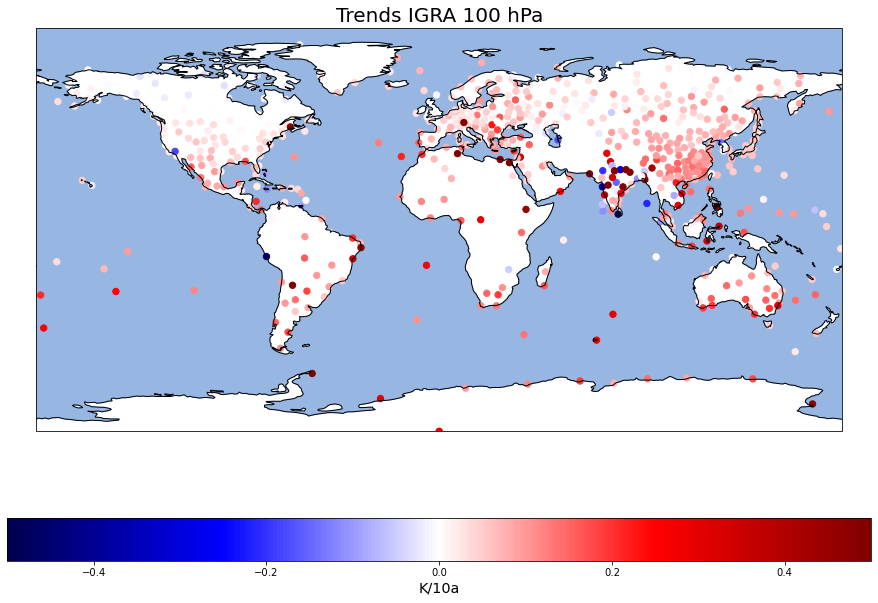

In [101]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib as mpl

ax = plt.axes([0, 0, 1, 1], projection=ccrs.PlateCarree())
ax.add_feature(cfeature.OCEAN, zorder=0)
ax.coastlines()

da = igra.dropna()
reduced = np.asarray(da['station_name'])*3650
longitudes = list(da['location_longitude'])
latitudes = list(da['location_latitude'])
plt.scatter(longitudes, latitudes, s=40, alpha=1,
            c= da['station_name']*3650,
            cmap='seismic',
            vmin=-0.5,
            vmax=0.5)
plt.colorbar(orientation='horizontal', label='K/10a')
plt.title('Trends IGRA 100 hPa')
plt.savefig('Trends_IGRA')




In [90]:
da['station_name']*3650

59       0.538223
67       0.194503
75       0.102948
79      -0.146108
82      0.0971308
          ...    
4839     0.100464
5625    0.0542698
5724     0.271694
5744      0.33954
5749     0.514737
Name: station_name, Length: 595, dtype: object

In [27]:
reduced.min()

-0.21274725274725964

In [24]:
import matplotlib.cm as cm
# colors = np.array(colors, dtype=np.float)
# col = [cm.tab20(x) for x in range(len(reduced))]
# col = [cm.tab20(x/len(reduced)) for x in range(len(reduced))]


In [28]:
col

[(0.050383, 0.029803, 0.527975, 1.0),
 (0.050383, 0.029803, 0.527975, 1.0),
 (0.050383, 0.029803, 0.527975, 1.0),
 (0.050383, 0.029803, 0.527975, 1.0),
 (0.050383, 0.029803, 0.527975, 1.0),
 (0.050383, 0.029803, 0.527975, 1.0),
 (0.063536, 0.028426, 0.533124, 1.0),
 (0.063536, 0.028426, 0.533124, 1.0),
 (0.063536, 0.028426, 0.533124, 1.0),
 (0.063536, 0.028426, 0.533124, 1.0),
 (0.063536, 0.028426, 0.533124, 1.0),
 (0.063536, 0.028426, 0.533124, 1.0),
 (0.075353, 0.027206, 0.538007, 1.0),
 (0.075353, 0.027206, 0.538007, 1.0),
 (0.075353, 0.027206, 0.538007, 1.0),
 (0.075353, 0.027206, 0.538007, 1.0),
 (0.075353, 0.027206, 0.538007, 1.0),
 (0.075353, 0.027206, 0.538007, 1.0),
 (0.086222, 0.026125, 0.542658, 1.0),
 (0.086222, 0.026125, 0.542658, 1.0),
 (0.086222, 0.026125, 0.542658, 1.0),
 (0.086222, 0.026125, 0.542658, 1.0),
 (0.086222, 0.026125, 0.542658, 1.0),
 (0.086222, 0.026125, 0.542658, 1.0),
 (0.096379, 0.025165, 0.547103, 1.0),
 (0.096379, 0.025165, 0.547103, 1.0),
 (0.096379, 

In [9]:
def savetoarray(file, dataset: str='IGRA', dest: str='./temp100/'):
    yr = file.split('/')[5]
    plev = 10000
    chunk = pd.read_csv(file, header=12, index_col=False, usecols=['station_name', 'observed_value', 'air_pressure'])
    stations = chunk.station_name.drop_duplicates()
    for i in stations:
        if not os.path.isfile( dest + dataset + '_' + i + '_' + yr + '_' + str(plev) + ".p"):
            da = chunk[chunk.station_name == i]
            da = da[da.air_pressure == plev]
            pickle.dump( np.asarray(da.observed_value), open( dest + dataset + '_' + i + '_' + yr + '_' + str(plev) + ".p", "wb" ))

In [ ]:
if __name__ == '__main__':
    pool = multiprocessing.Pool(processes=20)
    result_list = pool.map(savetoarray, files[10:20])
    print(result_list)

In [ ]:
print('!')

In [38]:
lon = igra.report_timestamp.drop_duplicates()
lat = igra.location_longitude.drop_duplicates()
print(len(lon))
print(len(lat))

1304
1132


In [10]:
# IGRA and its harmonized version
for i in range(len(files)):
    print(i)
    if i == 0:
#         igra = pandas.read_csv(files[i], header=12)
        igrah = pandas.read_csv(files_h[i], header=12)
    else:
#         igra = igra.append(pandas.read_csv(files[i], header=12))
        igrah = igrah.append(pandas.read_csv(files_h[i], header=12))

0
1
2
3
4


KeyboardInterrupt: 

In [ ]:
preslist = [10000, 20000, 50000, 85000,]
for i in range(len(preslist)):
    c = comp[comp.plev == preslist[i]]
    c.time = pandas.to_datetime(c.time, utc=True)
    xax = np.asarray(c.time)
    
    selected = c.ta
    datlen = len(selected)
    coefficients, residuals, _, _, _ = np.polyfit(range(datlen),selected,1,full=True)
    mse = residuals[0]/(datlen)
    nrmse = np.sqrt(mse)/(selected.max() - selected.min())

    fig, (ax1) = plt.subplots(1, 1)
    ax1.plot(xax, np.asarray(selected), label = 'COMP', alpha=0.7)
    ax1.plot(xax, [coefficients[0]*x + coefficients[1] for x in range(len(selected))], label = 'COMP trend')
    ax1.set(xlabel ='time [multiples of 12h]', ylabel='temperature [K]', title='COMP Trend '+str(int(preslist[i]/100))+'hPa '+loc)
    textstr = 'Slope ' + str(coefficients[0]) +'\n'+'NRMSE: ' + str(nrmse)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax1.text(0.03, 0.95, textstr, transform=ax1.transAxes, fontsize=16, verticalalignment='top', bbox=props)


    ax1.legend( loc='best')
    plt.show()
    plt.close(fig)